# 1. Setup and Data Loading

In [ ]:
# Install necessary libraries
%pip install pandas scikit-learn matplotlib seaborn transformers datasets bertviz accelerate>=0.26.0 datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


## 2. Loading the dataset

In [ ]:
# Load the dataset
df = pd.read_csv("/content/IMDB Dataset.csv")
df = df.rename(columns={"review": "text", "sentiment": "label"})

# Convert 'label' to numerical values
df['label'] = df['label'].map({'positive': 2, 'neutral': 1, 'negative': 0})  # If neutral not present, use only 0 and 2
df = df.dropna()

df.head()

,text,label
0,One of the other reviewers has mentioned that ...,2
1,A wonderful little production. <br /><br />The...,2
2,I thought this was a wonderful way to spend ti...,2
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",2


## 3. Traditional ML: TF-IDF + SVM




SVM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      4961
           2       0.89      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



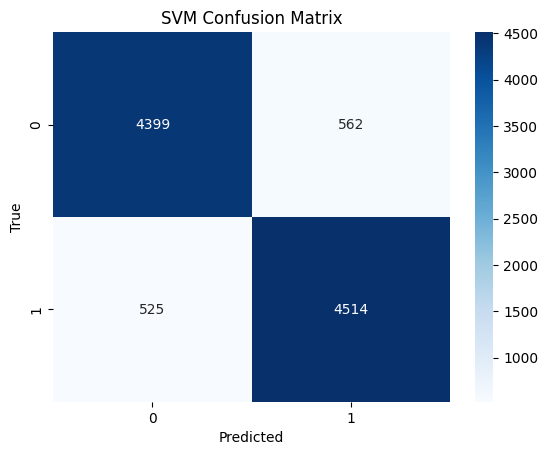

In [ ]:
## 4. Traditional ML: TF-IDF + SVM
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC())
])
pipeline.fit(X_train, y_train)
y_pred_svm = pipeline.predict(X_test)

print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

conf_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_svm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 4. Transformer Model (BERT)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stutie0005 (stutie0005-bennett-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.335200,0.278949


Epoch,Training Loss,Validation Loss
1,0.335200,0.278949
2,0.237800,0.257315


BERT Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      5065
           2       0.93      0.95      0.94      4935

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



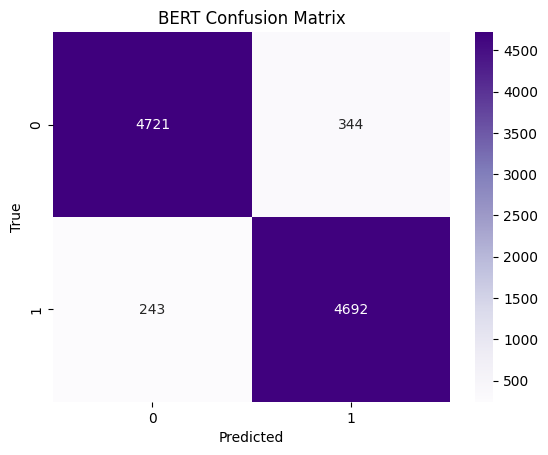

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = Dataset.from_pandas(df)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset = dataset.train_test_split(test_size=0.2, seed=42)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test']
)
trainer.train()

preds = trainer.predict(dataset['test'])
y_pred_bert = preds.predictions.argmax(axis=1)
y_true_bert = dataset['test']['labels']

print("BERT Classification Report:\n", classification_report(y_true_bert, y_pred_bert))

conf_bert = confusion_matrix(y_true_bert, y_pred_bert)
sns.heatmap(conf_bert, annot=True, fmt='d', cmap='Purples')
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 7. Conclusion
- SVM offers faster training and reasonable accuracy.
- BERT outperforms in complex sentence understanding and generalization.
- Explainability is easier with SVM; BERT needs dedicated tools like LIME, SHAP, or attention viz.

